<a href="https://colab.research.google.com/github/sam-thurman/asl_alphabet_image_classification/blob/master/notebooks/model_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

import lime
import lime.lime_image

print('Notebook running: keras ', keras.__version__)
import pandas as pd
import numpy as np
import scipy as math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# from PIL import Image

from sklearn.model_selection import train_test_split
from skimage.transform import resize
import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Model, Sequential
from keras import layers
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras import optimizers
from keras.optimizers import Adam
from keras.models import load_model

import detect_edges
import tensorflow as tf

import sys
import os

from imageio import imread, imsave

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Notebook running: keras  2.3.1
Instructions for updating:
Colocations handled automatically by placer.


/Users/sam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
Use tf.cast instead.


In [36]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/My\ Drive/

In [37]:
warnings.filterwarnings('ignore')

model = load_model('../models/model15.h5')
unet = load_model('../models/edge_detect/unet2.keras')

In [51]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [65]:
train_path = '../data/asl_alphabet_train'
validation_path = '../data/asl_alphabet_validation'
sam_path = '../data/asl_extra_val'
image_size = 200
batch_size = 32
valgen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=detect_edges.predict_custom_image,
                                                      rescale=1./255) 
val_generator = valgen.flow_from_directory(
                validation_path,  # directory for validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                color_mode='grayscale',
                shuffle=False)

# samgen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=(lambda x: tf.image.central_crop(x, central_fraction=1)))
# sam_generator = samgen.flow_from_directory(
#                 sam_path,  # directory for me-made validation images
#                 target_size=(image_size, image_size),
#                 batch_size=batch_size,
#                 class_mode='categorical',
#                 color_mode='rgb',
#                 shuffle=False)

Found 30 images belonging to 29 classes.


In [66]:
val_generator[0][0][0].shape

(200, 200, 1)

In [67]:
activations = activation_model.predict(np.expand_dims(val_generator[0][0][0], axis=0)) 
# Returns a list of five Numpy arrays: one array per layer activation

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

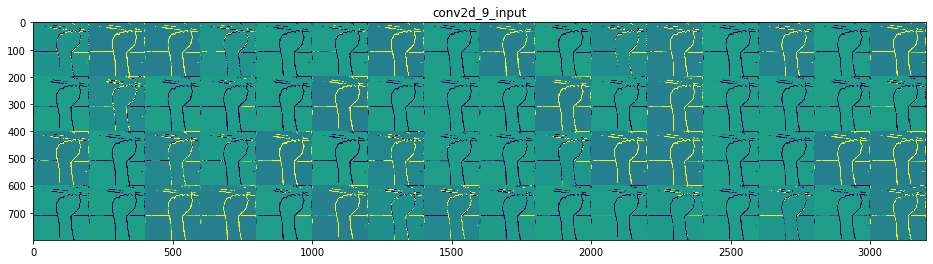

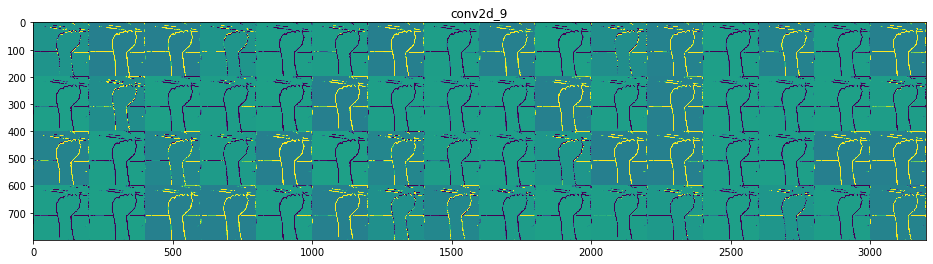

In [68]:
layer_names = []
for layer in activation_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [25]:
data_path = '../data/asl_alphabet_validation/'
Xi = skimage.io.imread(os.path.join(data_path, 'C/C_test.jpg'))
print(Xi.shape)
from skimage.color import rgb2gray
Xi = detect_edges.predict_custom_image(Xi)
# Xi = detect_edges.to_rgb1(Xi)


Xi.shape
# plt.imshow(Xi)
# Xi = np.expand_dims(Xi, axis=3)
# Xi = np.expand_dims(Xi, axis=0)
# Xi = resize(Xi,(1, 200,200, 1))
# print(Xi.shape)



# '''FOR GRAY'''
# data_path = '../data/asl_alphabet_validation/'
# Xi = skimage.io.imread(os.path.join(data_path, 'D/D_test.jpg'))
# from skimage.color import rgb2gray
# Xi = detect_edges.predict_custom_image(Xi)
# # Xi = detect_edges.to_rgb1(Xi)
# Xi = resize(Xi,(1,128,128,1))
# Xi.shape

(200, 200, 3)
(200, 3)


(200, 200, 1)

In [23]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 64)      640       
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 200, 64)      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2560000)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 29)                74240029  
Total params: 74,240,669
Trainable params: 74,240,669
Non-trainable params: 0
_________________________________________________________________


In [26]:
np.argmax(model.predict(np.expand_dims(Xi, axis=0)))

22

In [8]:
explainer = lime.lime_image.LimeImageExplainer()

(256, 256)


array([0.14847514, 0.12329506, 0.25937355, 0.12181437, 0.08140004,
       0.08335752, 0.0948503 , 0.10445231, 0.10922245, 0.11203209,
       0.12417781, 0.15367039, 0.17079793, 0.17767128, 0.1878564 ,
       0.16690311, 0.1469742 , 0.12781681, 0.11688189, 0.09432915,
       0.08988279, 0.10134126, 0.11232634, 0.10807307, 0.10599592,
       0.08747044, 0.06675205, 0.06160141, 0.06240786, 0.0646995 ,
       0.06737696, 0.06925454, 0.07250921, 0.08232663, 0.10095721,
       0.12011477, 0.11877261, 0.12205248, 0.12938774, 0.14214213,
       0.14839143, 0.15013325, 0.14820527, 0.11139435, 0.06745415,
       0.03901458, 0.02408591, 0.020705  , 0.01892101, 0.01570581,
       0.01513816, 0.01993279, 0.02827117, 0.04252155, 0.0689375 ,
       0.1019258 , 0.12299035, 0.12833343, 0.11364478, 0.11258033,
       0.12450343, 0.10853482, 0.08425923, 0.07130408, 0.06217976,
       0.06139514, 0.07823592, 0.08315729, 0.08541545, 0.08460101,
       0.07922047, 0.05504258, 0.04249369, 0.04001171, 0.03933

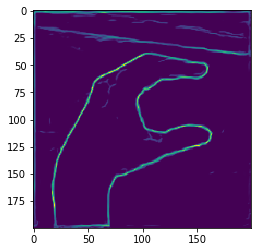

In [40]:
data_path = '../data/asl_alphabet_validation/'
Xi = skimage.io.imread(os.path.join(data_path, 'C/C_test.jpg'))
Xi = detect_edges.predict_custom_image(Xi)
Xi = resize(Xi,(200,200))
# Xi = detect_edges.to_rgb1(Xi)
plt.imshow(Xi)
Xi[0]

In [41]:
# Xi = np.expand_dims(Xi, axis=2)
val_generator[0][0][0].shape

(256, 256)


ValueError: could not broadcast input array from shape (256,256) into shape (200,200,3)

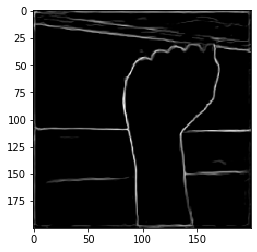

In [19]:
plt.imshow(Xi)

(200, 200, 3)


100%|██████████| 1/1 [00:00<00:00, 985.27it/s]


before predict (1, 200, 200, 3)
(200, 200, 3)
after predict (200, 200)
after expand axis2 (200, 200, 1)
after expand axis0 (1, 200, 200, 1)


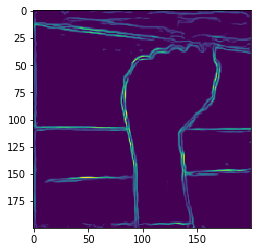

In [45]:
print(Xi.shape)
def predict(image):  
    print('before predict',image.shape)
    image = detect_edges.predict_custom_image(image)
    print('after predict',image.shape)
#     image = np.squeeze(image, axis=2)
    image = np.expand_dims(image, axis=2)
    print('after expand axis2',image.shape)
    image = np.expand_dims(image, axis=0)
    plt.imshow(array_to_img(image[0]))
    print('after expand axis0',image.shape)
    
    return model.predict(image)

explanation = explainer.explain_instance(Xi, predict, num_samples=1)


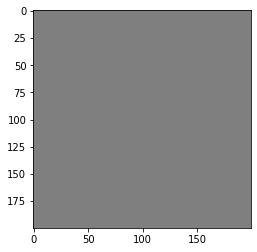

In [44]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))